## **Name**: Shaurya Bansal
## **Email**: sbansal8_be21@thapar.edu  
## **Roll No**: 102103012  
## **Group**: 4CO1  

## **Task**

Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

# Importing Libraries


In [46]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importing the Speech Commands dataset


In [2]:
DATASET_PATH = '/kaggle/input/speech-commands'

data_dir = pathlib.Path(DATASET_PATH)

In [82]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
all_commands = commands[(commands != 'README.md') & (commands != 'testing_list.txt')& (commands != 'validation_list.txt') & (commands!= 'LICENSE')]
commands = commands[(commands != 'README.md') & (commands != 'testing_list.txt')& (commands != 'validation_list.txt') & (commands != 'background_noise') & (commands!= 'LICENSE')]
print('Commands:', commands)

Commands: ['no' 'two' 'backward' 'four' 'five' 'nine' 'right' 'follow'
 '_background_noise_' 'visual' 'off' 'yes' 'six' 'dog' 'learn' 'left'
 'bird' 'forward' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree' 'seven'
 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat' 'sheila']


In [13]:
commands.size

36

In [11]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [16]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [17]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### plotting a few audio waveforms:

In [19]:
label_names[[1,1,3,0]]

array(['backward', 'backward', 'bird', '_background_noise_'], dtype='<U18')

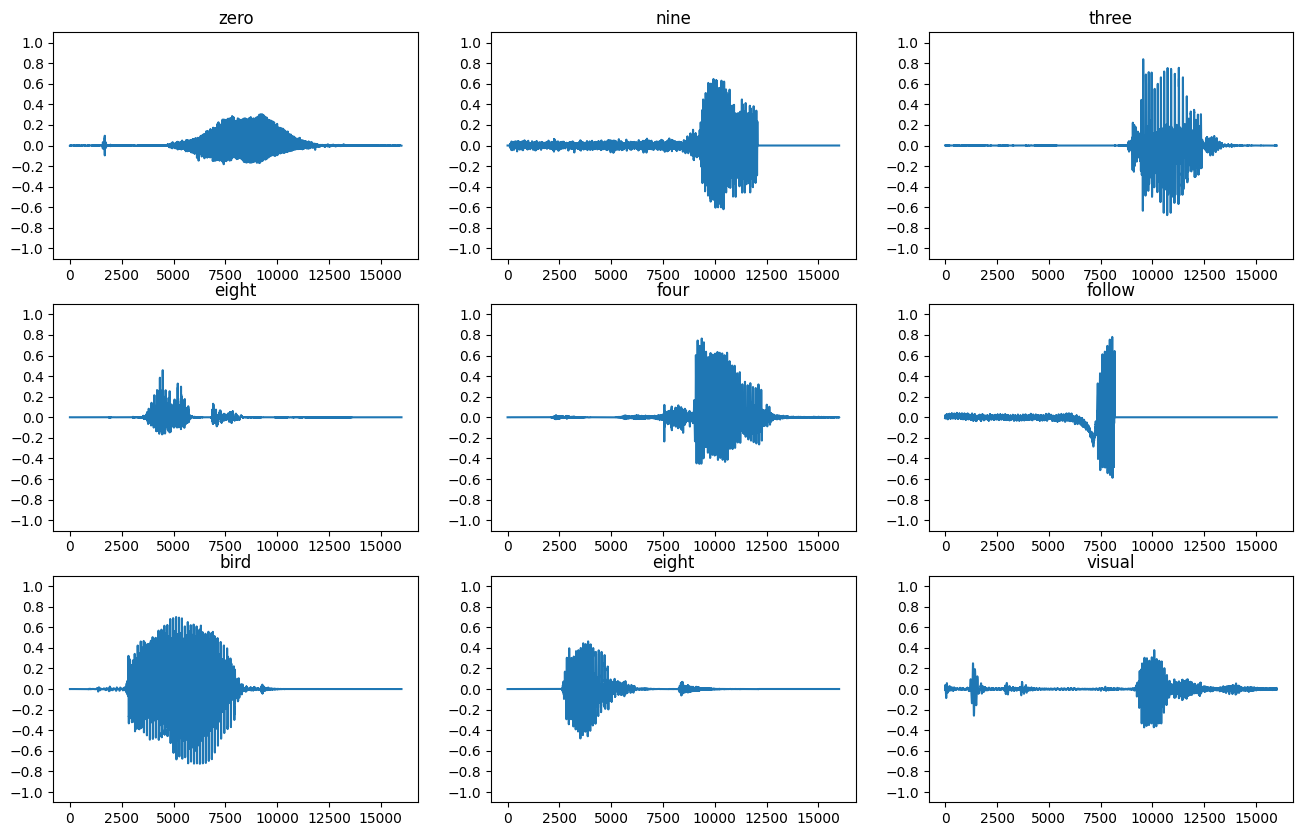

In [20]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Statistical Analysis

In [21]:
from collections import Counter

# Count the number of files in each category
def count_files_per_class(dataset_dir):
    class_counts = Counter()
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
    return class_counts

class_counts = count_files_per_class(data_dir)
print("Number of files per class:\n", class_counts)

Number of files per class:
 Counter({'five': 4052, 'zero': 4052, 'yes': 4044, 'seven': 3998, 'no': 3941, 'nine': 3934, 'down': 3917, 'one': 3890, 'two': 3880, 'go': 3880, 'stop': 3872, 'six': 3860, 'on': 3845, 'left': 3801, 'eight': 3787, 'right': 3778, 'off': 3745, 'four': 3728, 'three': 3727, 'up': 3723, 'dog': 2128, 'wow': 2123, 'house': 2113, 'marvin': 2100, 'bird': 2064, 'happy': 2054, 'cat': 2031, 'sheila': 2022, 'bed': 2014, 'tree': 1759, 'backward': 1664, 'visual': 1592, 'follow': 1579, 'learn': 1575, 'forward': 1557, '_background_noise_': 7})


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


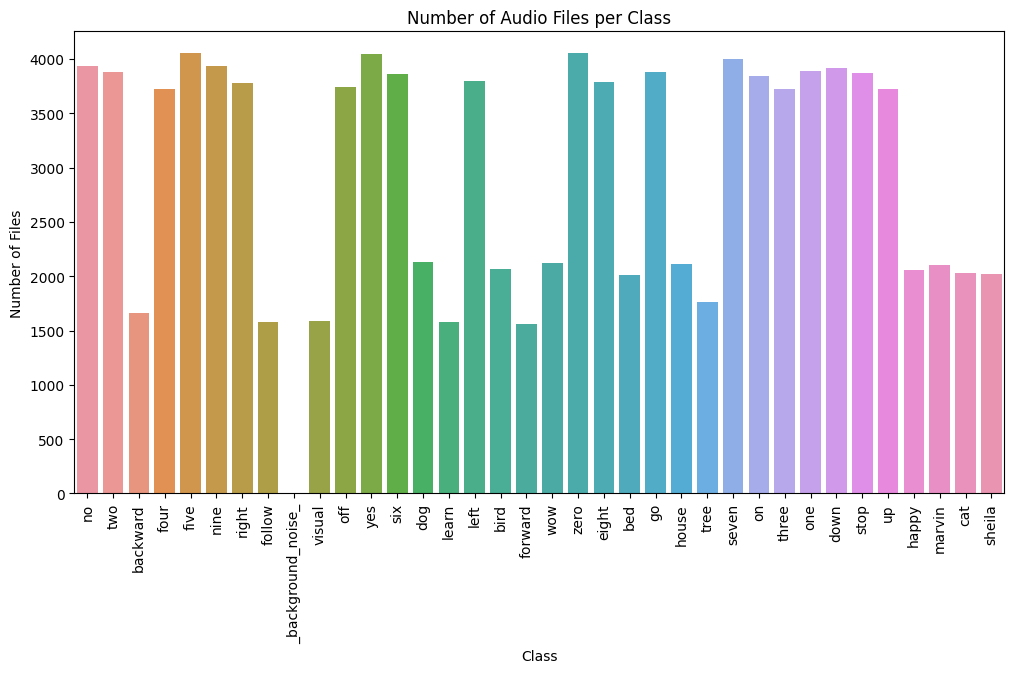

In [22]:
 # Visualize the number of audio files per class using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Number of Audio Files per Class")
plt.xlabel("Class")
plt.ylabel("Number of Files")
plt.show()

In [59]:
import wave
import mimetypes

In [60]:



# Function to calculate the duration of a WAV file
def calculate_duration(file_path):
    mime_type, _ = mimetypes.guess_type(file_path)
    if mime_type == 'audio/x-wav':  # Check if the file is a WAV file
        with wave.open(file_path, 'r') as audio_file:
            frames = audio_file.getnframes()
            rate = audio_file.getframerate()
            duration = frames / float(rate)
        return duration
    else:
        return None  # Return None for non-WAV files

# Calculate the duration for each audio file
def get_durations_per_class(dataset_dir):
    durations_per_class = {cls: [] for cls in class_counts}
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                duration = calculate_duration(file_path)
                if duration is not None:  # Only add valid durations
                    durations_per_class[folder].append(duration)
    return durations_per_class

# Re-run the analysis
durations_per_class = get_durations_per_class(data_dir)

# Example: Print average duration for each class
for cls, durations in durations_per_class.items():
    if durations:  # Ensure there are durations to calculate stats
        print(f"Class: {cls}, Average Duration: {np.mean(durations):.2f} seconds")
    else:
        print(f"Class: {cls}, No valid audio files found")


Class: no, Average Duration: 0.98 seconds
Class: two, Average Duration: 0.98 seconds
Class: backward, Average Duration: 0.99 seconds
Class: four, Average Duration: 0.98 seconds
Class: five, Average Duration: 0.98 seconds
Class: nine, Average Duration: 0.98 seconds
Class: right, Average Duration: 0.98 seconds
Class: follow, Average Duration: 0.98 seconds
Class: _background_noise_, Average Duration: 66.57 seconds
Class: visual, Average Duration: 0.98 seconds
Class: off, Average Duration: 0.98 seconds
Class: yes, Average Duration: 0.98 seconds
Class: six, Average Duration: 0.99 seconds
Class: dog, Average Duration: 0.97 seconds
Class: learn, Average Duration: 0.97 seconds
Class: left, Average Duration: 0.98 seconds
Class: bird, Average Duration: 0.97 seconds
Class: forward, Average Duration: 0.98 seconds
Class: wow, Average Duration: 0.97 seconds
Class: zero, Average Duration: 0.99 seconds
Class: eight, Average Duration: 0.98 seconds
Class: bed, Average Duration: 0.97 seconds
Class: go, A

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


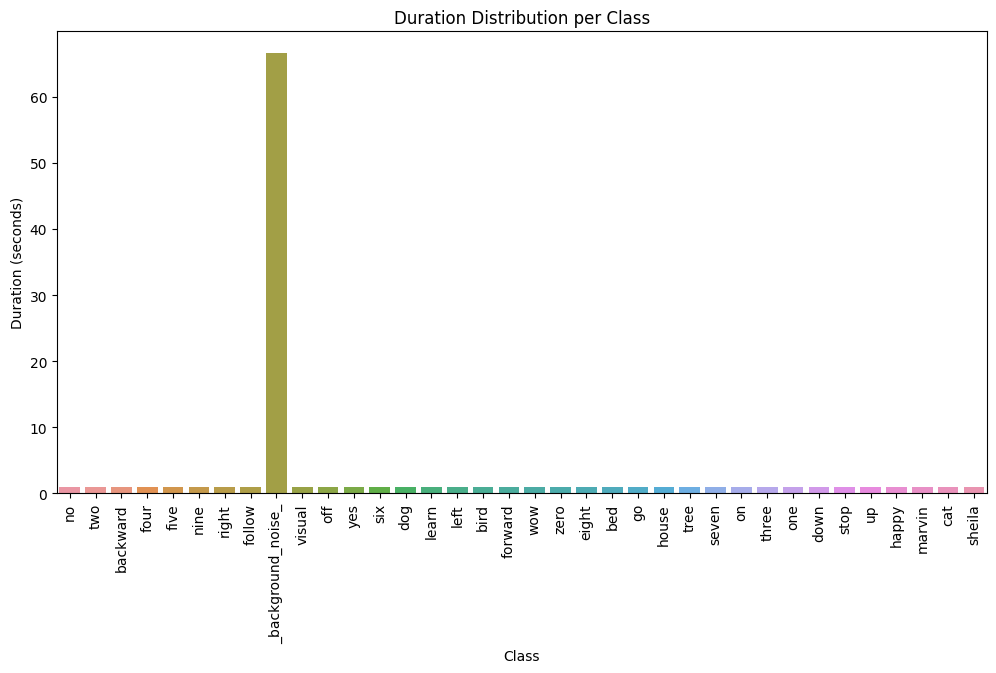

In [65]:
# Box plot of durations per class
plt.figure(figsize=(12, 6))
durations = [np.mean(durations_per_class[cls]) for cls in class_counts.keys()]
sns.barplot(x=list(durations_per_class.keys()), y=durations)
plt.xticks(rotation=90)
plt.title("Duration Distribution per Class")
plt.xlabel("Class")
plt.ylabel("Duration (seconds)")
plt.show()


In [71]:
# Calculate the file size of each WAV file
def get_file_sizes_per_class(dataset_dir):
    sizes_per_class = {cls: [] for cls in class_counts}
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                size = os.path.getsize(file_path) / 1024  # File size in KB
                sizes_per_class[folder].append(size)
    return sizes_per_class

sizes_per_class = get_file_sizes_per_class(data_dir)
for cls, sizes in sizes_per_class.items():
    if sizes:  # Ensure there are durations to calculate stats
        print(f"Class: {cls}, Average Size: {np.mean(sizes):.2f} KB")
    else:
        print(f"Class: {cls}, No valid audio files found")



Class: no, Average Size: 30.67 KB
Class: two, Average Size: 30.72 KB
Class: backward, Average Size: 30.87 KB
Class: four, Average Size: 30.76 KB
Class: five, Average Size: 30.80 KB
Class: nine, Average Size: 30.82 KB
Class: right, Average Size: 30.74 KB
Class: follow, Average Size: 30.73 KB
Class: _background_noise_, Average Size: 1783.22 KB
Class: visual, Average Size: 30.74 KB
Class: off, Average Size: 30.82 KB
Class: yes, Average Size: 30.78 KB
Class: six, Average Size: 30.90 KB
Class: dog, Average Size: 30.43 KB
Class: learn, Average Size: 30.49 KB
Class: left, Average Size: 30.82 KB
Class: bird, Average Size: 30.34 KB
Class: forward, Average Size: 30.82 KB
Class: wow, Average Size: 30.36 KB
Class: zero, Average Size: 30.89 KB
Class: eight, Average Size: 30.69 KB
Class: bed, Average Size: 30.37 KB
Class: go, Average Size: 30.63 KB
Class: house, Average Size: 30.51 KB
Class: tree, Average Size: 30.36 KB
Class: seven, Average Size: 30.82 KB
Class: on, Average Size: 30.73 KB
Class: th

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


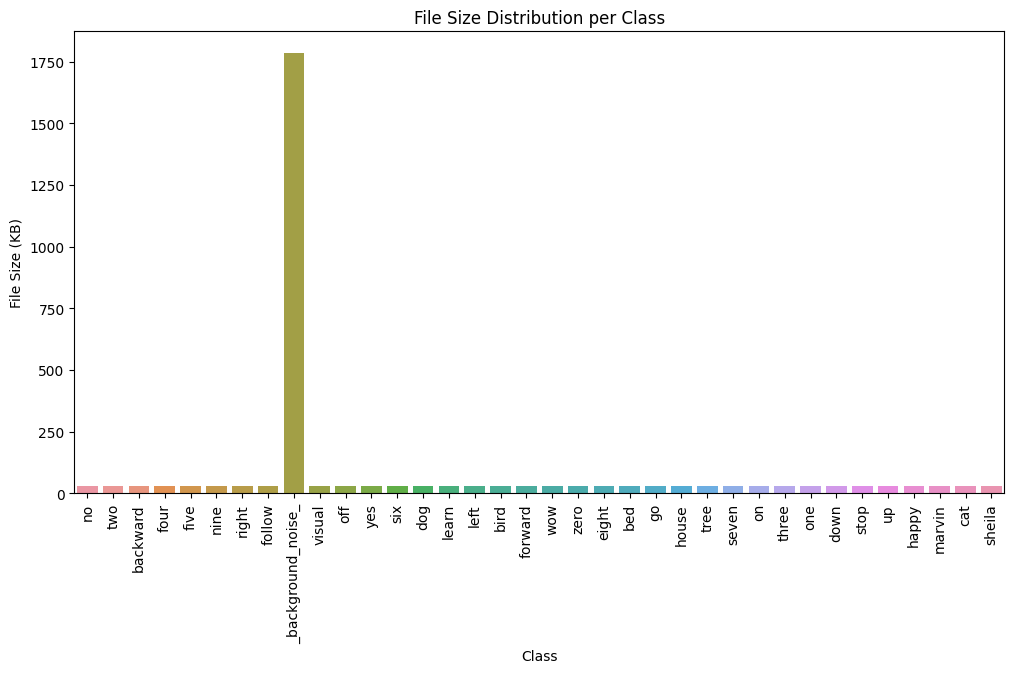

In [72]:
# Visualize file size distribution with box plot
plt.figure(figsize=(12, 6))
sizes = [np.mean(sizes_per_class[cls]) for cls in sizes_per_class.keys()]
sns.barplot(x=list(sizes_per_class.keys()), y=sizes)
plt.xticks(rotation=90)
plt.title("File Size Distribution per Class")
plt.xlabel("Class")
plt.ylabel("File Size (KB)")
plt.show()

Skipping invalid WAV file: /kaggle/input/speech-commands/_background_noise_/README.md


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


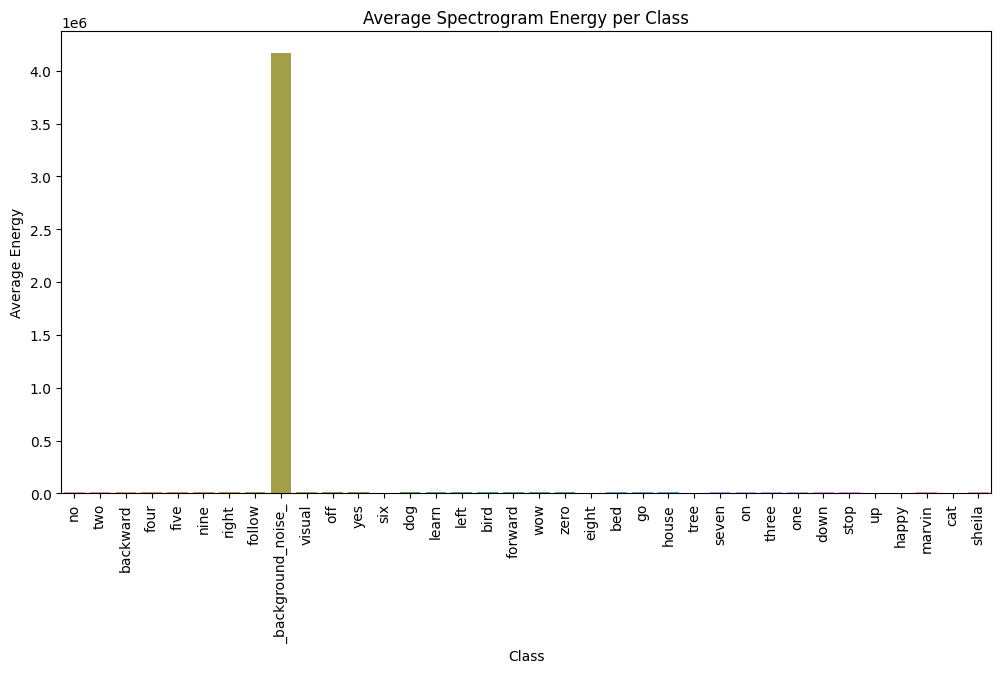

In [75]:
import tensorflow as tf

def is_valid_wav(file_path):
    """Check if a file is a valid WAV file by trying to decode it."""
    try:
        # Try to decode the file
        waveform, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
        return True
    except:
        return False

# Updated function to get spectrogram energies per class
def get_spectrogram_energies_per_class(dataset_dir):
    energies_per_class = {}
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            energies_per_class[folder] = []
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if is_valid_wav(file_path):  # Check if it's a valid WAV file
                    waveform, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
                    spectrogram = get_spectrogram(tf.squeeze(waveform, axis=-1))
                    energy = calculate_spectrogram_energy(spectrogram)
                    energies_per_class[folder].append(energy)
                else:
                    print(f"Skipping invalid WAV file: {file_path}")
    return energies_per_class

# Now call the function
spectrogram_energies_per_class = get_spectrogram_energies_per_class(data_dir)

# Visualize average spectrogram energy per class
avg_energies = [np.mean(spectrogram_energies_per_class[cls]) for cls in spectrogram_energies_per_class.keys()]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(spectrogram_energies_per_class.keys()), y=avg_energies)
plt.xticks(rotation=90)
plt.title("Average Spectrogram Energy per Class")
plt.xlabel("Class")
plt.ylabel("Average Energy")
plt.show()

# Converting waveforms to spectograms

In [26]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [27]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: zero
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [28]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

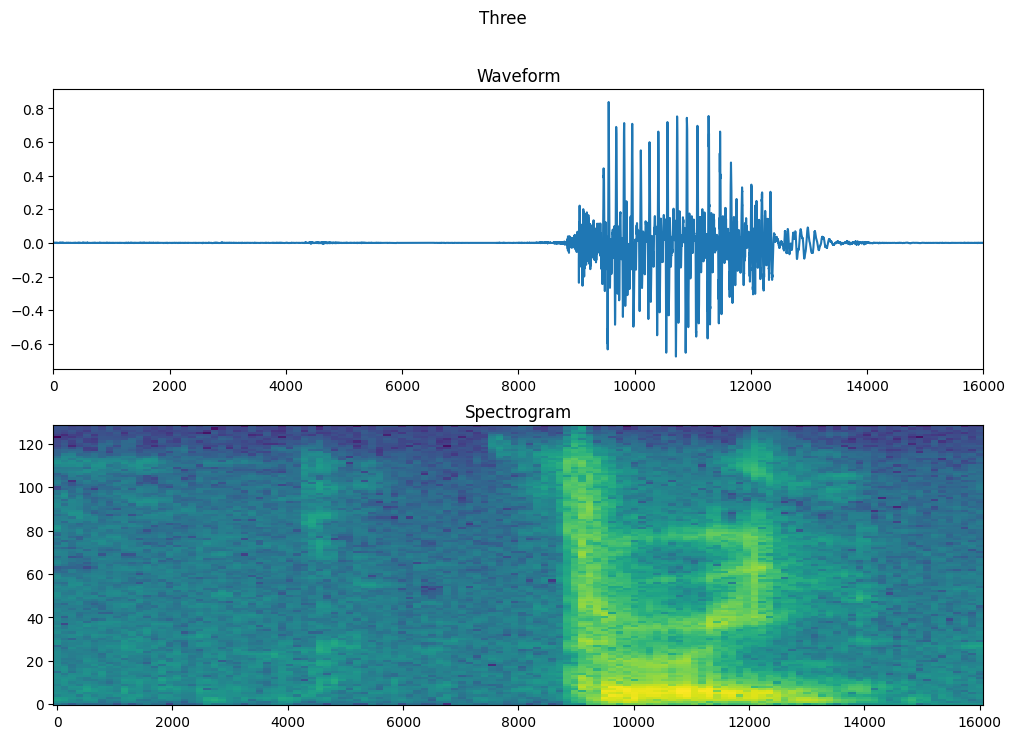

In [29]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [30]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [32]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

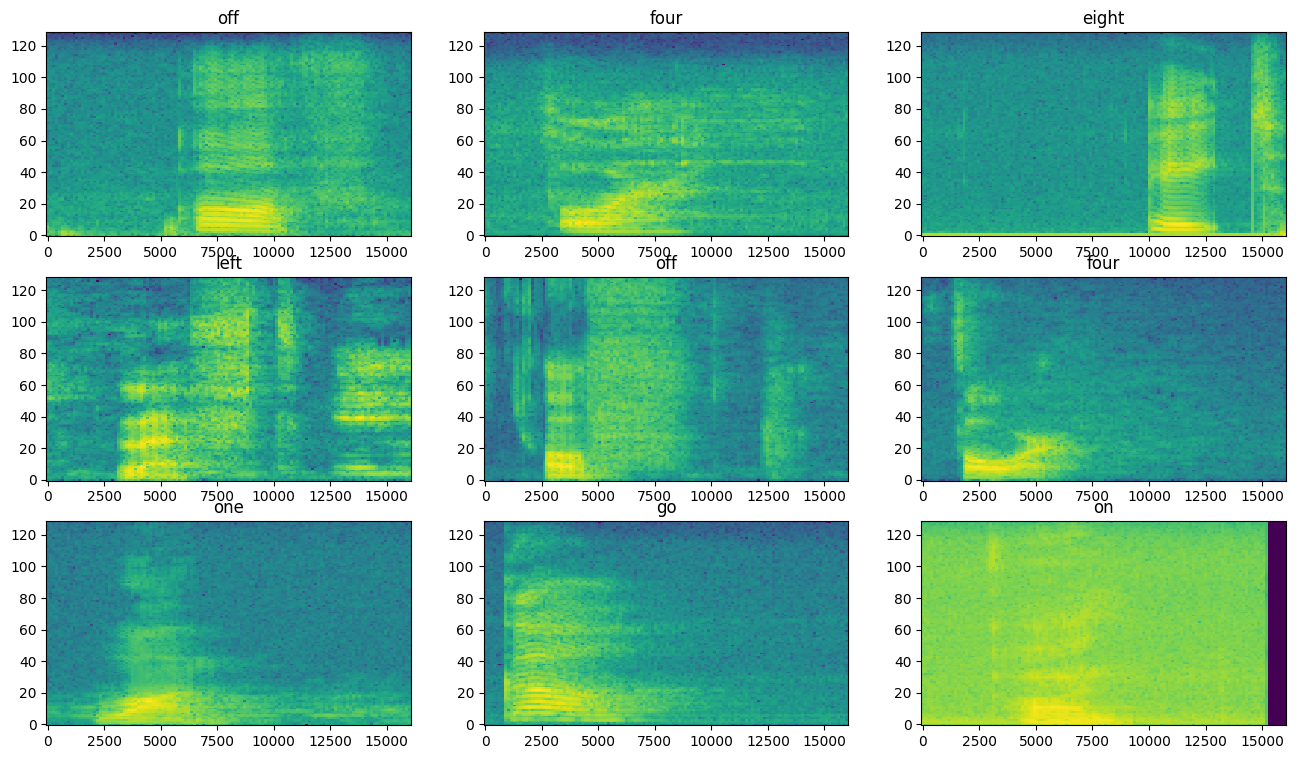

In [33]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build and train the model

In [34]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## CNN

In [51]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),

    
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),

])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,668,263 (21.62 MB)

 Trainable params: 5,668,260 (21.62 MB)

 Non-trainable params: 3 (16.00 B)

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [54]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.3542 - loss: 2.3132 - val_accuracy: 0.7780 - val_loss: 0.7394
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.7521 - loss: 0.8386 - val_accuracy: 0.8344 - val_loss: 0.5593
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8240 - loss: 0.5926 - val_accuracy: 0.8486 - val_loss: 0.5091
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8592 - loss: 0.4707 - val_accuracy: 0.8605 - val_loss: 0.4815
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8838 - loss: 0.3793 - val_accuracy: 0.8597 - val_loss: 0.5066
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8997 - loss: 0.3248 - val_accuracy: 0.8627 - val_loss: 0.5104
Epoch 6: early stopping


Text(0, 0.5, 'Accuracy [%]')

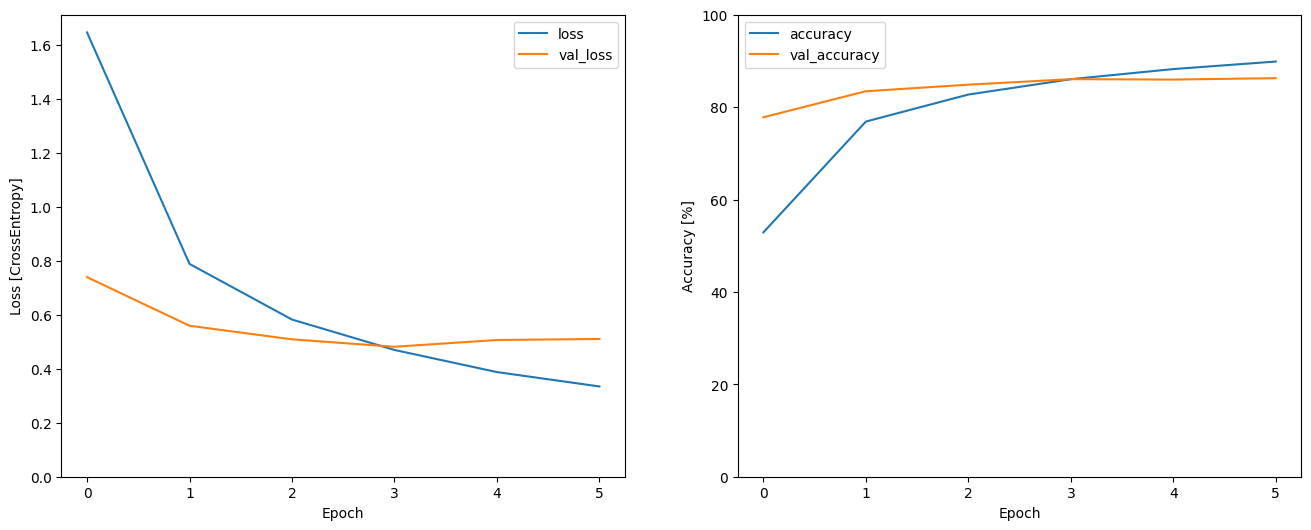

In [55]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Evaluating the model performance

In [56]:
model.evaluate(test_spectrogram_ds, return_dict=True)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8726 - loss: 0.4854


{'accuracy': 0.8682945370674133, 'loss': 0.5015120506286621}

## Displaying a confusion matrix


In [41]:
y_pred = model.predict(test_spectrogram_ds)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [42]:
y_pred = tf.argmax(y_pred, axis=1)

In [44]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

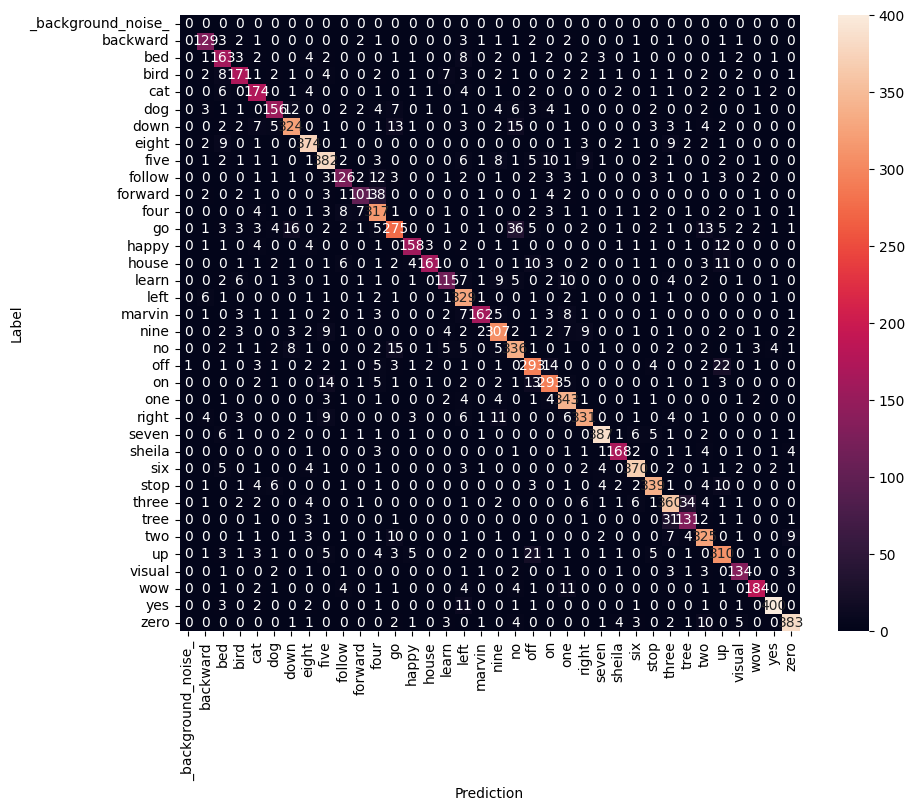

In [45]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [90]:
new_label_names = label_names[label_names!='_background_noise_']

In [91]:
print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, target_names=new_label_names)
print(report)


Classification Report:

              precision    recall  f1-score   support

    backward       0.93      0.85      0.89       152
         bed       0.87      0.80      0.83       200
        bird       0.86      0.79      0.83       218
         cat       0.88      0.82      0.85       206
         dog       0.83      0.80      0.81       213
        down       0.90      0.83      0.86       390
       eight       0.93      0.94      0.93       408
        five       0.87      0.86      0.87       442
      follow       0.83      0.67      0.74       172
     forward       0.85      0.69      0.76       157
        four       0.81      0.90      0.85       360
          go       0.82      0.78      0.80       388
       happy       0.94      0.87      0.91       192
       house       0.92      0.82      0.87       213
       learn       0.80      0.62      0.70       173
        left       0.84      0.92      0.88       351
      marvin       0.90      0.87      0.89       204
  

In [80]:
print(label_names)
label_names.size

['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


36

In [92]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8712
Recall: 0.8683
F1 Score: 0.8679


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

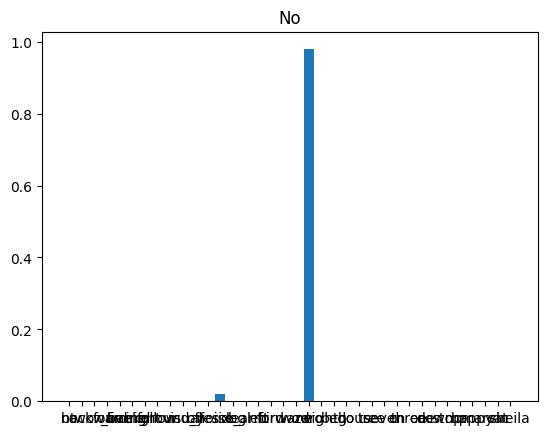

In [93]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = all_commands
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [94]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [95]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-22.44802  ,  -9.794997 ,  -4.065273 ,  -6.4094553, -10.604947 ,
           1.0664281,   4.4916034,  -8.167933 , -14.772827 ,  -7.928079 ,
         -16.078104 ,  -6.8644004,   7.3767805, -15.960123 ,  -8.467247 ,
           2.473945 ,  -3.3626487,  -8.863232 ,  -1.7417763,  11.334059 ,
         -13.747555 , -12.933054 ,  -6.5409584,  -8.933922 , -14.239162 ,
         -10.358431 , -16.28421  ,  -9.121165 ,  -9.8573475, -13.802007 ,
          -0.5177473, -10.702936 ,  -1.6190726,   2.2883942,  -1.8908608,
           0.7634537]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [96]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-22.44802  ,  -9.794997 ,  -4.065273 ,  -6.4094553, -10.604947 ,
           1.0664281,   4.4916034,  -8.167933 , -14.772827 ,  -7.928079 ,
         -16.078104 ,  -6.8644004,   7.3767805, -15.960123 ,  -8.467247 ,
           2.473945 ,  -3.3626487,  -8.863232 ,  -1.7417763,  11.334059 ,
         -13.747555 , -12.933054 ,  -6.5409584,  -8.933922 , -14.239162 ,
         -10.358431 , -16.28421  ,  -9.121165 ,  -9.8573475, -13.802007 ,
          -0.5177473, -10.702936 ,  -1.6190726,   2.2883942,  -1.8908608,
           0.7634537]], dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>}